## 加载数据集

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(2018)

n = 25000
half_n = int(n/2)
X = np.zeros((n, 224, 224, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)
# 获得当前目录
current_dir = os.getcwd()
for i in tqdm(range(half_n)):
    X[i] = cv2.resize(cv2.imread(current_dir + '/data/train/cat/cat.%d.jpg' % i, cv2.IMREAD_COLOR), (224, 224))
    X[i + half_n] = cv2.resize(cv2.imread(current_dir + '/data/train/dog/dog.%d.jpg' % i, cv2.IMREAD_COLOR), 
                                        (224, 224))

y[half_n:] = 1
X.shape

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
100%|██████████| 12500/12500 [04:48<00:00, 43.39it/s]


(25000, 224, 224, 3)

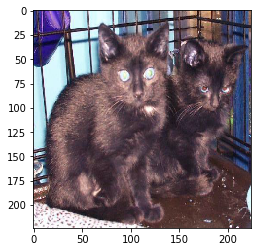

Size =  (224, 224, 3)


In [2]:
random_img = np.random.choice(range(n))
plt.imshow(X[random_img], cmap='gray')
plt.show()
print("Size = ", X[random_img].shape)

## 分为训练集和验证集

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

## 构建模型

In [8]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, Dense, Dropout
from keras.models import Model

In [9]:
# X_train = Lambda(xception.preprocess_input)(X_train)

base_model = ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False, pooling = 'avg')

for layer in base_model.layers:
    layer.trainable = False
    
x = Dropout(0.25)(base_model.output)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

## 训练模型

In [10]:
model.fit(X_train, y_train, batch_size=16, epochs=5, validation_data=(X_valid, y_valid))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 229s 11ms/step - loss: 0.1194 - acc: 0.9509 - val_loss: 0.0685 - val_acc: 0.9750
Epoch 2/5
20000/20000 [==============================] - 227s 11ms/step - loss: 0.0817 - acc: 0.9691 - val_loss: 0.0502 - val_acc: 0.9816
Epoch 3/5
20000/20000 [==============================] - 227s 11ms/step - loss: 0.0786 - acc: 0.9700 - val_loss: 0.0647 - val_acc: 0.9770
Epoch 4/5
20000/20000 [==============================] - 227s 11ms/step - loss: 0.0754 - acc: 0.9702 - val_loss: 0.0848 - val_acc: 0.9740
Epoch 5/5
20000/20000 [==============================] - 227s 11ms/step - loss: 0.0768 - acc: 0.9702 - val_loss: 0.0770 - val_acc: 0.9768


## 模型可视化

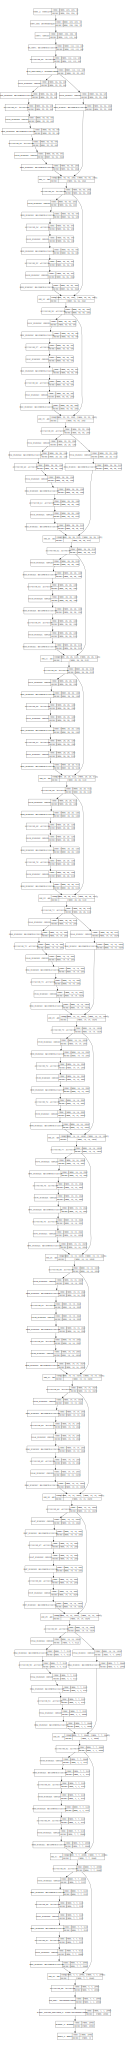

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## CAM 可视化

In [12]:
zip([x.name for x in model.layers], range(len(model.layers)))

In [13]:
weights = model.layers[177].get_weights()[0]
model2 = Model(model.input, [model.layers[172].output, model.output])

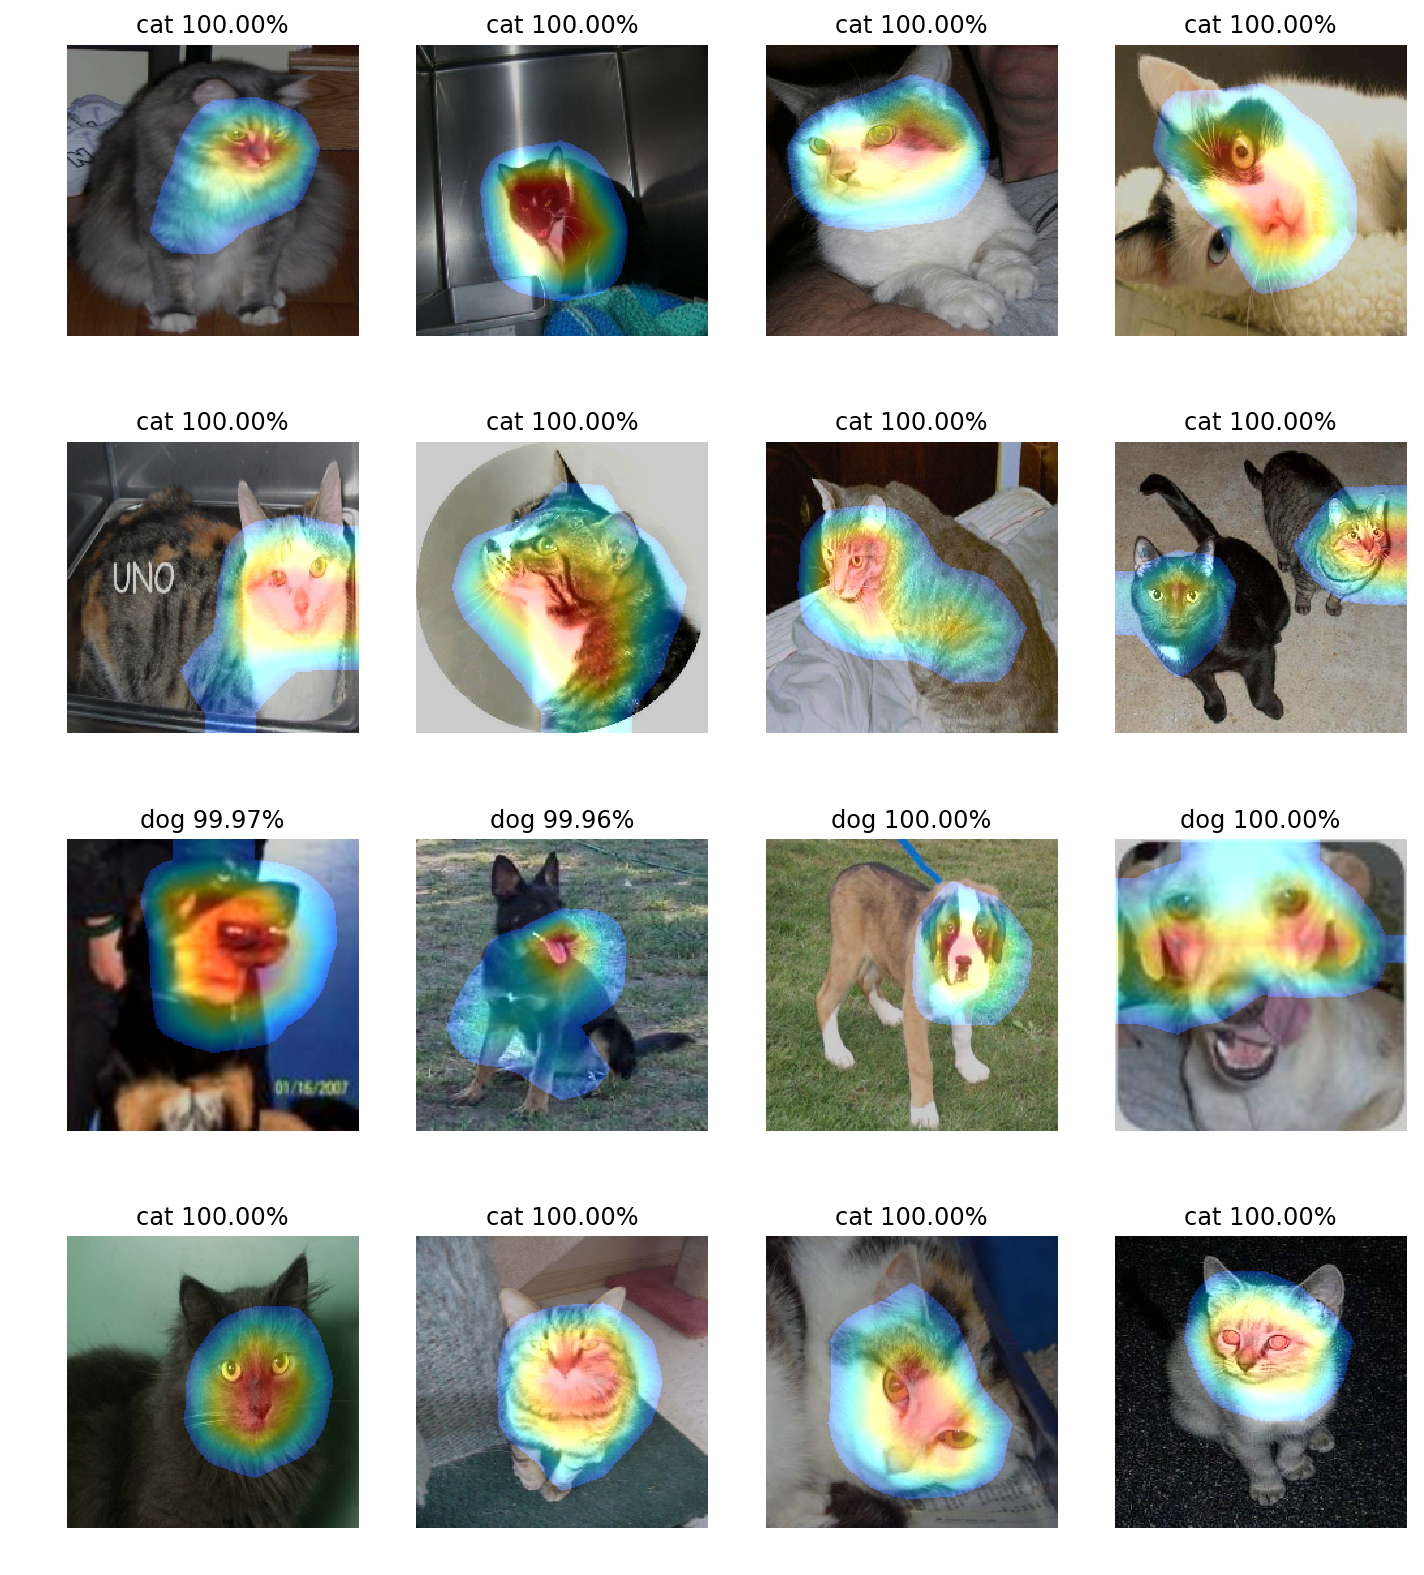

In [15]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 14))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = cv2.imread(current_dir + '/data/test/test/%d.jpg' % random.randint(1, 12500))
    img = cv2.resize(img, (224, 224))
    x = img.copy()
    x.astype(np.float32)
    out, prediction = model2.predict(np.expand_dims(x, axis=0))

    prediction = prediction[0]
    out = out[0]

    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))

    cam = (prediction - 0.5) * np.matmul(out, weights)
    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8

    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0

    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

    plt.axis('off')
    plt.imshow(out[:,:,::-1])

## Fine-tune

In [16]:
for layer in model.layers[140:]:
    layer.trainable = True

In [17]:
model.fit(X_train, y_train, batch_size=16, epochs=5, validation_data=(X_valid, y_valid))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
   16/20000 [..............................] - ETA: 3:45 - loss: 0.2518 - acc: 0.8750

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


20000/20000 [==============================] - 226s 11ms/step - loss: 0.0712 - acc: 0.9728 - val_loss: 0.0688 - val_acc: 0.9780
Epoch 2/5
20000/20000 [==============================] - 227s 11ms/step - loss: 0.0678 - acc: 0.9741 - val_loss: 0.0639 - val_acc: 0.9792
Epoch 3/5
20000/20000 [==============================] - 227s 11ms/step - loss: 0.0706 - acc: 0.9724 - val_loss: 0.0688 - val_acc: 0.9788
Epoch 4/5
20000/20000 [==============================] - 227s 11ms/step - loss: 0.0691 - acc: 0.9736 - val_loss: 0.0600 - val_acc: 0.9810
Epoch 5/5
20000/20000 [==============================] - 227s 11ms/step - loss: 0.0687 - acc: 0.9746 - val_loss: 0.0595 - val_acc: 0.9802
